In [70]:
import sys, os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List, Tuple, Callable, Any, Dict

from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.midstep_composites import midstep_composition_transformation, midstep_se3_groundstate
from methods.midstep_composites import midstep_composition_transformation_correction
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
from methods.free_energy import calculate_midstep_triads, midstep_excess_vals
from methods.PolyCG.polycg.SO3 import so3

midstep_composition_transformation_correction

# from methods.PolyCG.polycg.SO3 import so3
# from methods.PolyCG.polycg.transforms.transform_SO3 import euler2rotmat_so3
# from methods.PolyCG.polycg.cgnaplus import cgnaplus_bps_params
# from methods.PolyCG.polycg.transforms.transform_algebra2group import algebra2group_lintrans, group2algebra_lintrans

np.set_printoptions(linewidth=250,precision=5,suppress=True)

In [2]:
genstiff = GenStiffness(method='hybrid')   # alternatively you can use the 'crystal' method for the Olson data
# genstiff = GenStiffness(method='md')   # alternatively you can use the 'crystal' method for the Olson data
seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
seq601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"

seq601 = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT"

seq = seq601
    
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)
triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)

midstep_constraint_locations = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]
nuc_stiffs = np.load('consts/nuc_stiffs.npy')

# dim = 6
# for i in range(len(K)//dim):
#     print('------------------------------------')
#     print(nuc_stiffs[i])


### Midstep Locations

In [3]:
def get_midstep_locations(left_open: int, right_open: int):
    MIDSTEP_LOCATIONS = [
        2, 6, 14, 17, 24, 29, 
        34, 38, 45, 49, 55, 59, 
        65, 69, 76, 80, 86, 90, 
        96, 100, 107, 111, 116, 121, 
        128, 131, 139, 143
    ]
    if left_open + right_open > len(MIDSTEP_LOCATIONS):
        return []
    return MIDSTEP_LOCATIONS[left_open:len(MIDSTEP_LOCATIONS)-right_open]
    
mid_locs = get_midstep_locations(3,6)
print(len(mid_locs))
print(mid_locs)

19
[17, 24, 29, 34, 38, 45, 49, 55, 59, 65, 69, 76, 80, 86, 90, 96, 100, 107, 111]


In [76]:
midstep_triads = calculate_midstep_triads(
    midstep_constraint_locations,
    nuctriads
)
gmid = np.zeros((len(midstep_triads)-1,6))
for i in range(len(midstep_triads)-1):
    gmid[i] = so3.se3_rotmat2euler(np.linalg.inv(midstep_triads[i]) @ midstep_triads[i+1])
    print(f'{i}: {gmid[i]}')


0: [ 0.03701 -0.03156  2.39246  0.05723 -0.00677  1.32549]
1: [-0.10296 -0.57611 -1.47367 -0.22598  0.59785  2.51961]
2: [-0.02376 -0.13162  1.77612 -0.02741  0.0006   0.99844]
3: [ 0.32132 -0.73877 -2.0518  -0.32209  0.54344  2.18523]
4: [ 0.04597 -0.44367  3.06484  0.14096 -0.17474  1.68807]
5: [0.09169 0.78968 2.8168  0.22309 0.40248 1.6085 ]
6: [ 0.11834 -0.31172  2.41249 -0.03699 -0.33433  1.31004]
7: [ 0.08681 -0.69264 -1.96666 -0.37117  0.59683  2.16678]
8: [-0.10847 -0.23681  2.46031 -0.03504 -0.10864  1.33036]
9: [ 0.01183 -0.85201 -2.73293  0.22987  0.55489  1.865  ]
10: [ 0.17018 -0.42287  2.47143  0.06909 -0.19788  1.31397]
11: [ 0.15343 -0.7035  -2.51351 -0.19651  0.44591  1.93623]
12: [ 0.05899 -0.2868   2.46727  0.01437 -0.17451  1.34392]
13: [-0.00141 -0.67034 -2.00477 -0.17894  0.63352  2.22474]
14: [-0.05798 -0.28441  2.46506 -0.03356 -0.12964  1.34865]
15: [-0.15162 -0.70068 -2.51623  0.0017   0.57675  1.91166]
16: [-0.17074 -0.42659  2.47299 -0.12412 -0.23584  1.303

### Diagonal Matrices

In [4]:
def get_block_diag(stiffs: np.ndarray, dim: int = 6, left_open: int = 0, right_open: int = 0):
    if left_open + right_open > len(stiffs):
        return []
    right_id = len(stiffs)- right_open
    mddim = (len(stiffs)-left_open-right_open)*dim
    M = np.zeros((mddim,mddim))
    for i in range(len(stiffs)-left_open-right_open):
        M[i*dim:(i+1)*dim,i*dim:(i+1)*dim] = stiffs[i+left_open]
    return M

def set_block_diag(M: np.ndarray,dim: int = 6):
    M_diag = np.zeros(M.shape)
    for i in range(len(M)//dim):
        M_diag[i*dim:(i+1)*dim,i*dim:(i+1)*dim] = M[i*dim:(i+1)*dim,i*dim:(i+1)*dim]
    return M_diag

def select_partial(M, dim: int = 6, left_open: int = 0, right_open: int = 0, marginalize=True):
    n = len(M)//dim
    if marginalize:
        return np.linalg.inv(np.linalg.inv(M)[left_open*dim:(n-right_open)*dim,left_open*dim:(n-right_open)*dim])
    return M[left_open*dim:(n-right_open)*dim,left_open*dim:(n-right_open)*dim]

### Calculate K

------------------------------------
[[  3.0282   22.95322 -16.09785 -40.42169 -45.23759  15.51329]
 [ 22.95154  10.69332  12.88158  37.28228 -48.76198  82.08185]
 [-16.09736  12.88167 109.65533  67.7421  -31.89796   9.39788]
 [-40.42182  37.2823   67.74208  26.16685  15.22622  36.92677]
 [-45.23748 -48.76196 -31.89796  15.22622  52.87443 -23.45244]
 [ 15.51327  82.08178   9.3979   36.92676 -23.45244 208.02646]]
[[ 68.31115  10.0568  -16.63129 -33.2989    1.24314  41.47985]
 [ 10.0568   81.41818  33.78174 -10.35239 -59.83771  55.44149]
 [-16.63129  33.78174 168.67984  45.01888 -43.66767 -23.24231]
 [-33.2989  -10.35239  45.01888  96.36422  23.78331  47.85496]
 [  1.24314 -59.83771 -43.66767  23.78331 125.1933   16.57614]
 [ 41.47985  55.44149 -23.24231  47.85496  16.57614 534.27901]]
[[ 65.28295 -12.89642  -0.53344   7.12279  46.48073  25.96655]
 [-12.89474  70.72486  20.90016 -47.63467 -11.07573 -26.64036]
 [ -0.53393  20.90008  59.02451 -22.72322 -11.76971 -32.64019]
 [  7.12292 -47.

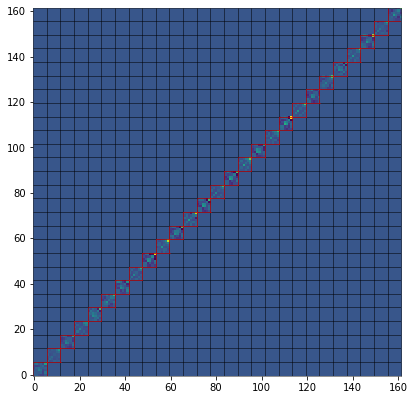

In [5]:
def calculate_K(
    groundstate: np.ndarray,
    stiffmat: np.ndarray,
    left_open: int,
    right_open: int,
    nucleosome_triads: np.ndarray,
    nuc_stiffs: np.ndarray,
    use_correction: bool = True,
) -> np.ndarray:

    midstep_constraint_locations = get_midstep_locations(left_open, right_open)

    if len(midstep_constraint_locations) <= 1:
        n = len(stiffmat)
        F_pi = -0.5*n * np.log(2*np.pi)
        # matrix term
        logdet_sign, logdet = np.linalg.slogdet(stiffmat)
        F_mat = 0.5*logdet
        F = F_mat + F_pi  
        return F, F, 0, 0
    
    
    midstep_constraint_locations = sorted(list(set(midstep_constraint_locations)))

    midstep_triads = calculate_midstep_triads(
        midstep_constraint_locations,
        nucleosome_triads
    )
    
    # find contraint excess values
    excess_vals = midstep_excess_vals(
        groundstate,
        midstep_constraint_locations,
        midstep_triads
    )  
    C = excess_vals.flatten()
        
    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        groundstate,
        midstep_constraint_locations
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
     
    P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
    stiffmat_rearranged = P @ stiffmat_transformed @ P.T

    # select fluctuating, constraint and coupling part of matrix
    N  = len(stiffmat)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    MF = stiffmat_rearranged[:NF,:NF]
    MC = stiffmat_rearranged[NF:,NF:]
    MM = stiffmat_rearranged[NF:,:NF]
    
    MFi = np.linalg.inv(MF)
    b = MM.T @ C
    
    ########################################
    ########################################
    if use_correction:
        alpha = -MFi @ b
        
        gs_transf_perm = np.concatenate((alpha,C))
        gs_transf = P.T @ gs_transf_perm
        gs = inv_transform @ gs_transf
    
        gs = gs.reshape((len(gs)//6,6))
        # find composite transformation
        transform, replaced_ids = midstep_composition_transformation_correction(
            groundstate,
            midstep_constraint_locations,
            -gs
        )
        
        # transform stiffness matrix
        inv_transform = np.linalg.inv(transform)
        stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
        
        # # rearrange stiffness matrix
        # full_replaced_ids = list()
        # for i in range(len(replaced_ids)):
        #     full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
        
        # P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
        stiffmat_rearranged = P @ stiffmat_transformed @ P.T

        # select fluctuating, constraint and coupling part of matrix
        N  = len(stiffmat)
        NC = len(full_replaced_ids)
        NF = N-NC
        
        MF = stiffmat_rearranged[:NF,:NF]
        MC = stiffmat_rearranged[NF:,NF:]
        MM = stiffmat_rearranged[NF:,:NF]
        
    
    ########################################
    ########################################
    
    MFi = np.linalg.inv(MF)

    # marginalize stiffness matrix to midstep DoFs
    M_mid = MC - MM @ MFi @ MM.T
    # print(f'E_enth = {0.5*C.T @ M_mid @ C}')

    ########################################
    # calculate K
    
    # generate M_md
    M_md = get_block_diag(nuc_stiffs,left_open=left_open,right_open=right_open)
    # calculate K
    K = M_md - M_mid
    # reduced K 
    K_red = set_block_diag(K)
    return K_red,M_md, M_mid
    
seq = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT" 
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)
    
left_open=0
right_open=0
K,M_md, M_mid = calculate_K(groundstate,stiffmat,left_open,right_open,nuctriads,nuc_stiffs=nuc_stiffs)

# left_open=14
# right_open=4
# K1 = calculate_K(groundstate,stiffmat,left_open,right_open,nuctriads,nuc_stiffs=nuc_stiffs)

# print(K.shape)
# print(K1.shape)
# print(np.sum(K[6*left_open:,6*left_open:]-K1))

# print(K[6*left_open:,6*left_open:])
# print(K1)


stiff = K
dims = 6

fig = plt.figure(figsize=(17./2.54,17.2/2.54))
ax1 = fig.add_subplot(111)
# Bilinear interpolation - this will look blurry
ax1.imshow(stiff, interpolation='none', cmap='viridis')
# ax1.imshow(cov, interpolation='none', cmap='viridis')

# plot blocks
for l in range(1,len(stiff)//dims+1):
    ax1.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(stiff)-0.5],color='black',lw=0.5)
    ax1.plot([0-0.5,len(stiff)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

    ax1.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax1.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax1.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
    ax1.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
    
    
ax1.set_xlim((-0.5,len(stiff)-.5))
ax1.set_ylim((-0.5,len(stiff)-.5))

# ax1.set_xlim((-0.5,12-.5))
# ax1.set_ylim((-0.5,12-.5))

dim = 6
for i in range(len(K)//dim):
    print('------------------------------------')
    print(K[i*dim:(i+1)*dim,i*dim:(i+1)*dim])
    print(M_md[i*dim:(i+1)*dim,i*dim:(i+1)*dim])
    print(M_mid[i*dim:(i+1)*dim,i*dim:(i+1)*dim])
    print(nuc_stiffs[i])


### Load K matrix

In [6]:
fn = 'MDParams/Kmat_nucleosome.npy'
K = np.load(fn)

### Calculate 

In [7]:

def nucleosome_free_energy(
    groundstate: np.ndarray,
    stiffmat: np.ndarray,    
    left_open: int,
    right_open: int,
    nucleosome_triads: np.ndarray,
    K: np.ndarray,
    use_correction: bool = True,
) -> np.ndarray:

    midstep_constraint_locations = get_midstep_locations(left_open, right_open)

    if len(midstep_constraint_locations) <= 1:
        n = len(stiffmat)
        F_pi = -0.5*n * np.log(2*np.pi)
        # matrix term
        logdet_sign, logdet = np.linalg.slogdet(stiffmat)
        F_mat = 0.5*logdet
        F = F_mat + F_pi  
        Fdict = {
            'F': F,
            'F_entropy' : F,
            'F_enthalpy': 0,
            'F_jacob'   : 0,
            'F_free'    : F
        }
        return Fdict
    
    midstep_constraint_locations = sorted(list(set(midstep_constraint_locations)))

    midstep_triads = calculate_midstep_triads(
        midstep_constraint_locations,
        nucleosome_triads
    )
    
    # find contraint excess values
    excess_vals = midstep_excess_vals(
        groundstate,
        midstep_constraint_locations,
        midstep_triads
    )  
    C = excess_vals.flatten()
        
    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        groundstate,
        midstep_constraint_locations
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
     
    P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
    stiffmat_rearranged = P @ stiffmat_transformed @ P.T

    # select fluctuating, constraint and coupling part of matrix
    N  = len(stiffmat)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    MF = stiffmat_rearranged[:NF,:NF]
    MC = stiffmat_rearranged[NF:,NF:]
    MM = stiffmat_rearranged[NF:,:NF]
    
    MFi = np.linalg.inv(MF)
    b = MM.T @ C
    
    ########################################
    ########################################
    if use_correction:
        alpha = -MFi @ b
        
        gs_transf_perm = np.concatenate((alpha,C))
        gs_transf = P.T @ gs_transf_perm
        gs = inv_transform @ gs_transf
    
        gs = gs.reshape((len(gs)//6,6))
        # find composite transformation
        transform, replaced_ids = midstep_composition_transformation_correction(
            groundstate,
            midstep_constraint_locations,
            -gs
        )
        
        # transform stiffness matrix
        inv_transform = np.linalg.inv(transform)
        stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
        
        stiffmat_rearranged = P @ stiffmat_transformed @ P.T

        # select fluctuating, constraint and coupling part of matrix
        N  = len(stiffmat)
        NC = len(full_replaced_ids)
        NF = N-NC
        
        MF = stiffmat_rearranged[:NF,:NF]
        MC = stiffmat_rearranged[NF:,NF:]
        MM = stiffmat_rearranged[NF:,:NF]
        
        MFi = np.linalg.inv(MF)
        b = MM.T @ C
    
    ########################################
    ########################################
    
    # constant energies
    F_const_C =  0.5 * C.T @ MC @ C
    F_const_b = -0.5 * b.T @ MFi @ b
    
    F_enthalpy = F_const_C + F_const_b
    
    
    K_partial = select_partial(K,left_open=left_open,right_open=right_open)
    Mtot_k = np.copy(stiffmat_rearranged)
    Mtot_k[NF:,NF:] += K_partial
    
    # print(stiffmat_rearranged[NF:NF+6,NF:NF+6])
    # print(Mtot_k[NF:NF+6,NF:NF+6])
    
    
    # entropy term
    n = len(Mtot_k)
    logdet_sign, logdet = np.linalg.slogdet(Mtot_k)
    F_pi = -0.5*n * np.log(2*np.pi)
    # matrix term
    F_mat = 0.5*logdet
    F_entropy = F_pi + F_mat
    F_jacob = np.log(np.linalg.det(transform))
    
    # free energy of unconstrained DNA
    ff_logdet_sign, ff_logdet = np.linalg.slogdet(stiffmat)
    ff_pi = -0.5*len(stiffmat) * np.log(2*np.pi)
    F_free = 0.5*ff_logdet + ff_pi
     
    # prepare output
    Fdict = {
        'F': F_entropy + F_jacob + F_enthalpy,
        'F_entropy' : F_entropy + F_jacob,
        'F_enthalpy': F_enthalpy,
        'F_jacob'   : F_jacob,
        'F_free'    : F_free
    }
    return Fdict
        

left_open  = 12
right_open = 0       
   
   
seq = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT"  
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)
        
nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K)

{'F': 1734.7159827882572,
 'F_entropy': 1694.6287603159,
 'F_enthalpy': 40.0872224723571,
 'F_jacob': -62.03455317321442,
 'F_free': 1657.6086060360667}

In [8]:
fn = 'MDParams/Kmat_nucleosome.npy'
K = np.load(fn)

# calibration sequences
seq601 = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT"

# seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
seq601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"
# seq601 = "CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGC"
# seq601 = "ATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATATA"

seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
seq = seq601
    
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)

print('F        F_enth  F_entr')
for i in range(15):
    left_open  = 0
    right_open = i*2    
    
    K_resc = np.copy(K)*0.75
    Fdict = nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K_resc)
    print('%.2f   %.2f   %.2f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free']))

F        F_enth  F_entr
116.45   63.69   52.76
109.83   61.32   48.51
100.73   56.66   44.07
93.46   51.11   42.34
81.98   43.61   38.37
69.58   36.21   33.37
60.60   32.25   28.35
51.41   27.31   24.11
42.82   23.72   19.11
33.51   18.96   14.56
24.92   15.52   9.40
15.75   9.45   6.30
7.55   4.34   3.21
1.54   0.87   0.67
0.00   0.00   0.00


In [9]:
left_open  = 0
right_open = 0   
Smin = 100
for i in range(1000):
    seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
    stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)
    Fdict = nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K_resc)
    F_S = Fdict['F_entropy']-Fdict['F_free']
    if F_S < Smin:
        Smin = F_S
        print('%.2f   %.2f   %.2f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free']))

120.62   67.72   52.89
118.52   65.63   52.89
122.22   71.04   51.18
118.19   67.70   50.50


KeyboardInterrupt: 

AA : 34.41314201929329
AA : 33.95592905598552
AT : 35.70836171170592
AT : 34.56167472419877
AC : 34.936802651179356
AC : 34.26171992751352
AG : 35.1120408994588
AG : 33.79663783609276
TA : 32.81837383806013
TA : 32.2676335185899
TT : 34.41314201929329
TT : 33.95592905598552
TC : 33.4668740316746
TC : 33.51741509741658
TG : 31.920093222236858
TG : 32.506897724676065
CA : 31.920093222236858
CA : 32.506897724676065
CT : 35.1120408994588
CT : 33.79663783609276
CC : 32.89367154461752
CC : 34.47988058366572
CG : 31.614132731619478
CG : 31.46759222125427
GA : 33.4668740316746
GA : 33.51741509741658
GT : 34.936802651179356
GT : 34.26171992751352
GC : 33.60707985549194
GC : 34.21622451918729
GG : 32.89367154461752
GG : 34.47988058366572


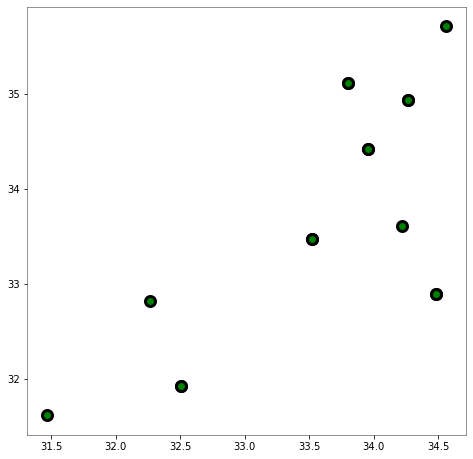

In [10]:

cry = []
md = []
genstiff_cry = GenStiffness(method='crystal')
genstiff_md = GenStiffness(method='md')
# genstiff = GenStiffness(method='md')
for key in genstiff.dimers.keys():
    # print(genstiff.dimers[key]["group_stiff"])
    stiff = genstiff_cry.dimers[key]["stiff"]
    det = np.linalg.det(stiff)
    val = np.log(det)
    cry.append(val)
    print(f'{key} : {val}')
    
    stiff = genstiff_md.dimers[key]["stiff"]
    det = np.linalg.det(stiff)
    val = np.log(det)
    md.append(val)
    print(f'{key} : {val}')
    
    
    
    
fig = plt.figure(figsize=(20/2.54,20/2.54))
ax1 = fig.add_subplot(111)

ax1.scatter(md,cry,s=100,edgecolor='black',color='green',linewidth=3)



### Distribution

In [69]:
fn = 'MDParams/Kmat_nucleosome.npy'
K = np.load(fn)

seq601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"

# seq601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"[::-1]

seq = seq601

F1s = []
F2s = []
Fs = []
    
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)
print('F        F_enth  F_entr')
for i in range(15):
    left_open  = 0
    right_open = i*2    
    
    K_resc = np.copy(K)*0.75
    Fdict = nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K_resc)
    # print('%.2f   %.2f   %.2f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free']))
    print('%.2f   %.2f   %.2f   %.3f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free'],Fdict['F_enthalpy']/(Fdict['F']-Fdict['F_free'])))
    
    F1 = Fdict['F'] - Fdict['F_free']
    F1 = Fdict['F_enthalpy']
    F1s.append(F1)
    
    # left_open  = i*2 
    # right_open = 0   
    
    # K_resc = np.copy(K)*0.75
    # Fdict = nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K_resc)
    # # print('%.2f   %.2f   %.2f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free']))
    # print('%.2f   %.2f   %.2f   %.3f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free'],Fdict['F_enthalpy']/(Fdict['F']-Fdict['F_free'])))
    
    # F2 = Fdict['F'] - Fdict['F_free']
    # F2 = Fdict['F_enthalpy']
    # F2s.append(F2)

    
    
    # Fs.append(0.5*(F1+F2))
    

F        F_enth  F_entr
116.45   63.69   52.76   0.547
109.83   61.32   48.51   0.558
100.73   56.66   44.07   0.562
93.46   51.11   42.34   0.547
81.98   43.61   38.37   0.532
69.58   36.21   33.37   0.520
60.60   32.25   28.35   0.532
51.41   27.31   24.11   0.531
42.82   23.72   19.11   0.554
33.51   18.96   14.56   0.566
24.92   15.52   9.40   0.623
15.75   9.45   6.30   0.600
7.55   4.34   3.21   0.575
1.54   0.87   0.67   0.565
0.00   0.00   0.00   nan


/tmp/ipykernel_39815/2833039541.py:23: RuntimeWarning: invalid value encountered in scalar divide
  print('%.2f   %.2f   %.2f   %.3f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free'],Fdict['F_enthalpy']/(Fdict['F']-Fdict['F_free'])))


# Absorption

[116.45096 111.55527 103.98871  96.34221  87.34519  77.60872  68.64336  61.20068  51.04801  41.25422  29.08328  19.62598   9.81069   2.71031]
[0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.00082 0.99918]


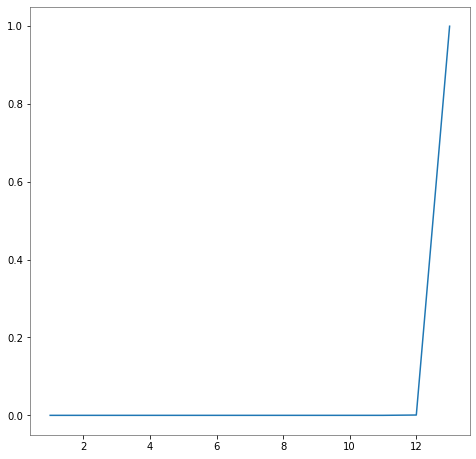

In [37]:
Fc = F2s

adsorb = 0
FF = np.array([Fc[i]+(14-i)*adsorb for i in range(14)])

print(FF)

prob = np.exp(-FF)
prob /= np.sum(prob)
wrap = np.arange(len(prob))

print(prob)

prob = prob[1:]
wrap = wrap[1:]

fig = plt.figure(figsize=(20/2.54,20/2.54))
ax1 = fig.add_subplot(111)

ax1.plot(wrap,prob)

[-20.31063 -16.68077 -15.34438 -14.88774 -16.39016 -17.78713 -15.74817 -14.69462 -12.28478 -11.0448   -8.47902  -8.55142  -7.65905  -5.12673]
[0.86773 0.02301 0.00605 0.00383 0.01721 0.06957 0.00906 0.00316 0.00028 0.00008 0.00001 0.00001 0.      0.     ]


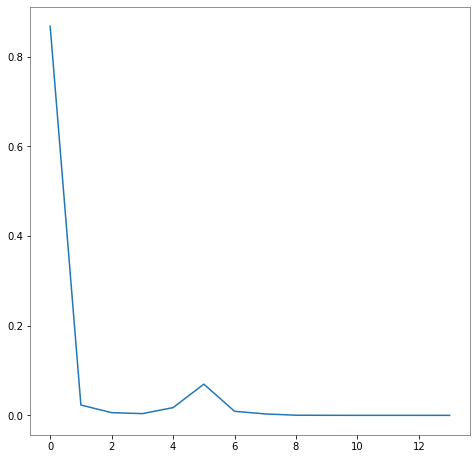

In [60]:
Fc = F1s

adsorb = -8.8
adsorb = -6.0
FF = np.array([Fc[i]+(14-i)*adsorb for i in range(14)])

print(FF)

prob = np.exp(-FF)
prob /= np.sum(prob)
wrap = np.arange(len(prob))

print(prob)


fig = plt.figure(figsize=(20/2.54,20/2.54))
ax1 = fig.add_subplot(111)

ax1.plot(wrap,prob)